# Introduction to Amazon Titan Image Generator Instant Customization Feature

#### Introduction

Amazon launched an exciting new feature for Titan Image Generator called "Isntant Customization". This powerful capability allows users to generate variations of an image by providing reference images along with a text prompt. The model can transfer styles from the reference images to create new images that combine elements of the prompt and the visual style of the references. This opens up new creative possibilities for generating custom images without the need for complex prompt engineering or model fine-tuning.

Moreover, Instant Customization feature can be used `in conjunction with fine-tuned` Titan Image Generator models. By combining these two features, customers can achieve even more precise control over the generated images and obtain results that closely align with their desired outcomes.

Some key features of Instant Customization include:

1. Generate image variations guided by up to 5 reference images

2. Preserve key aspects of the subject while transferring styles from references

3. Mix and combine styles from multiple reference images

4. Adjust the similarity strength to control how much the output resembles the refenreces


#### Prerequisites

Before diving into the code examples, ensure you have the following

1. An AWS account with access to Amazon Bedrock

2. Enable Titan Image Generator model access in Amazon Bedrock 

3. The necessary IAM permissions to invoke Amazon Bedrock models

4. AWS SDK for Python (Boto3) installed

In [ ]:
%pip install boto3 numpy pillow matplotlib --quiet

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [ ]:
import boto3
import io
import json
import base64
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

bedrock_runtime = boto3.client(service_name = "bedrock-runtime")

In [ ]:
# Define function for display
def plot_images(ref_image_path, base_images=None, custom_images=None, generated_images=None, strength_values=None, prompt=None, seed=None, comparison_mode=False):
    if comparison_mode:
        num_images = len(strength_values) + 1
        fig, axes = plt.subplots(1, num_images, figsize=((num_images) * 4, 5))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
    reference_image = Image.open(ref_image_path)
    max_size = (300, 300)
    reference_image.thumbnail(max_size)
    
    axes[0].imshow(np.array(reference_image))
    axes[0].set_title('Reference Image\n')
    axes[0].axis('off')

    if comparison_mode:
        if generated_images is None or len(generated_images) != len(strength_values):
            raise ValueError("The length of generated_images must match the length of strength_values.")
        for i in range(len(strength_values)):
            ind = i + 1
            axes[ind].imshow(np.array(generated_images[i]))
            axes[ind].set_title('Strength Value {}\n'.format(strength_values[i]))
            axes[ind].axis('off')
    else:
        axes[1].imshow(np.array(base_images[0]))
        axes[1].set_title('Without Reference\nSeed: {}'.format(seed))
        axes[1].axis('off')

        axes[2].imshow(np.array(custom_images[0]))
        axes[2].set_title('With Reference\nSeed: {}'.format(seed))
        axes[2].axis('off')
    
    if prompt:
        print("Prompt:{}\n".format(prompt))
    plt.show()

In [ ]:
# Define function to save the output
def save_image(base64_image, output_file):
    image_bytes = base64.b64decode(base64_image)
    image = Image.open(io.BytesIO(image_bytes))
    image.save(output_file)

### Example 1: Generating an image variation with a prompt and reference image(s)

To demostrate the power of Instant Customization, let's generate an image using a text prompt, first without any reference image, and then with a single reference image. We'll use the same prompt and seed for both generations to highlight the impact of the reference image on the output.

In [ ]:
# Define the prompt, reference image and path to store the generated images
prompt = "A cute cat"
reference_image_path = "Data/smila.jpg"
seed = 10000 # Can be any random number between 0 to 214783647

# Create output folder and specify output path
Path("Output/").mkdir(parents=True, exist_ok=True)
output_save_path = "Output/cute_cat.png" 

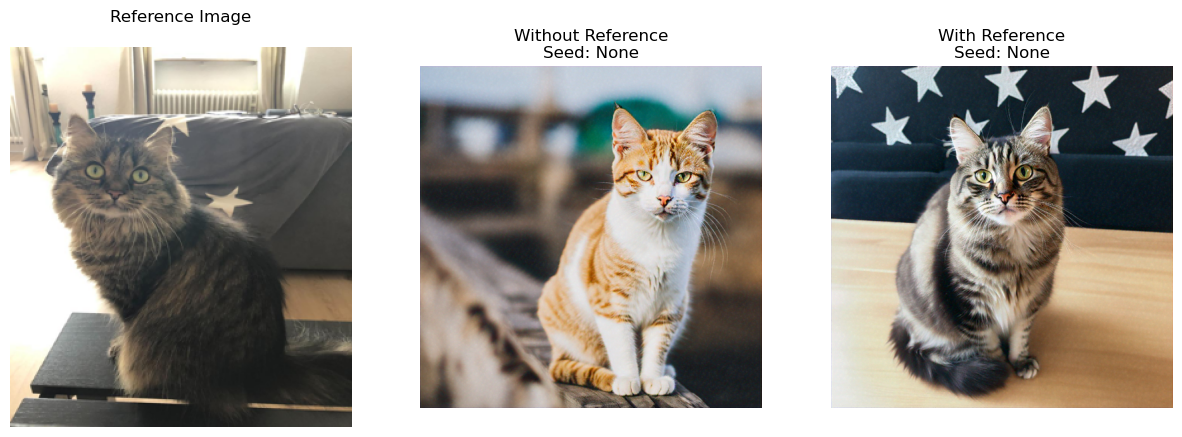

In [5]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image without reference
response_without_ref = bedrock_runtime.invoke_model(
    body = json.dumps({
        "taskType": "TEXT_IMAGE",
        "textToImageParams":{
            "text": prompt
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "premium",
            "seed": seed
        }
    }),
    modelId = "amazon.titan-image-generator-v1",
    accept="application/json",
    contentType="application/json"
    )

response_body_without_ref = json.loads(response_without_ref.get("body").read())

images_without_ref = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body_without_ref.get("images")
]

# Generate image with referece (Instant Customization feature)
response_with_ref = bedrock_runtime.invoke_model(
    body = json.dumps({
        "taskType": "IMAGE_VARIATION",
        "imageVariationParams": {
            "text": prompt,
            "images": [reference_image_base64], # can provide up to 5 reference images here
            "similarityStrength": 0.70,  # between 0.2 to 1
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "premium",
            "seed": seed
        }
    }),
    modelId = "amazon.titan-image-generator-v1",
    accept="application/json",
    contentType="application/json"
    )

response_body_with_ref = json.loads(response_with_ref.get("body").read())

images_with_ref = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body_with_ref.get("images")
]

# save output
save_image(response_body_with_ref.get("images")[0], output_save_path)

# plot output
plot_images(reference_image_path, images_without_ref, images_with_ref, prompt, seed)

The generated cat looks more like Smila!

### Example 2: Style Transfer with Instant Customization

Aamazon Titan Image Generator's Instant Customization feature allows users to achieve style trasnfer by providing reference images with a specific style. By using reference images in a particular style, such as a sketch or a painting, the generated image will inherit that style while still following the content of the text prompt. This powerful feature enables users to create images with desired styles without the need for complex style transfer techniques.

We can use the similar code samples as above to achieve it.

In [ ]:
# Define the prompt, reference image and path to store the generated images
prompt = "A cute cat plays with a ball"
reference_image_path = "Data/sketch_dog.png"
seed = 500 # Can be any random number between 0 to 214783647

# Create output folder and specify output path
Path("Output/").mkdir(parents=True, exist_ok=True)
output_save_path = "Output/cat_plays_ball.png" 

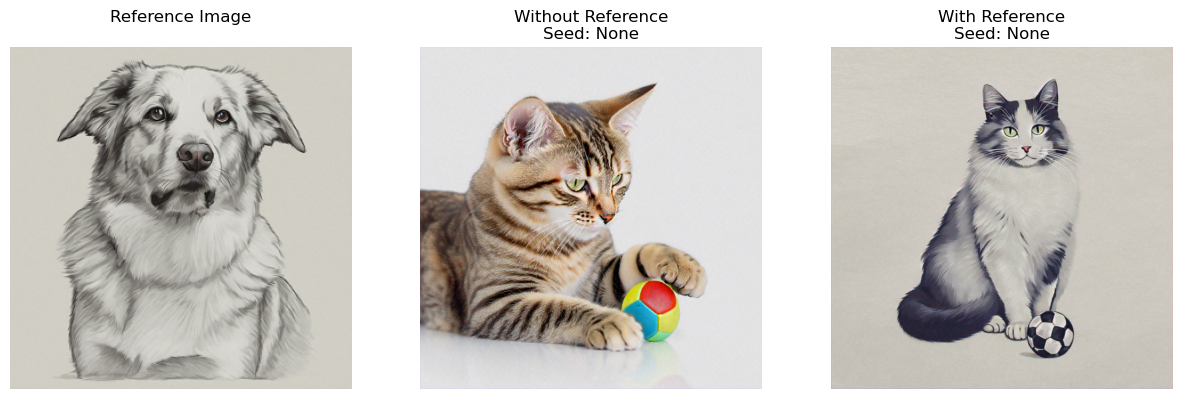

In [7]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image without reference
response_without_ref = bedrock_runtime.invoke_model(
    body = json.dumps({
        "taskType": "TEXT_IMAGE",
        "textToImageParams":{
            "text": prompt
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "premium",
            "seed": seed
        }
    }),
    modelId = "amazon.titan-image-generator-v1",
    accept="application/json",
    contentType="application/json"
    )

response_body_without_ref = json.loads(response_without_ref.get("body").read())

images_without_ref = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body_without_ref.get("images")
]

# Generate image with referece (Instant Customization feature)
response_with_ref = bedrock_runtime.invoke_model(
    body = json.dumps({
        "taskType": "IMAGE_VARIATION",
        "imageVariationParams": {
            "text": prompt,
            "images": [reference_image_base64], # can provide up to 5 reference images here
            "similarityStrength": 0.75,  # between 0.2 to 1
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "premium",
            "seed": seed
        }
    }),
    modelId = "amazon.titan-image-generator-v1",
    accept="application/json",
    contentType="application/json"
    )

response_body_with_ref = json.loads(response_with_ref.get("body").read())

images_with_ref = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body_with_ref.get("images")
]

# save output
save_image(response_body_with_ref.get("images")[0], output_save_path)

# plot output
plot_images(reference_image_path, images_without_ref, images_with_ref, prompt, seed)

### Example 3: Adjusting the Similarity Strength Parameter

Ths instant customization feature in Amazon Titan Image Generator allows users to control the extent to which the generated image resembles the reference image by adjusting the `similarityStrength` parameter. This parameter taks values between 0.2 and 1.0, with lower values producing images that deviate more from the reference image, and higher values resulting in images that more closely match the reference image's style and composition.

To illustrate the effect of the `similarityStrength` parameter, let's generate images using the same text prompt and reference image, but with three different values.

In [ ]:
# Define the prompt and reference image
prompt = "Ladybug on flower"
reference_image_path = "Data/carton_ladybug.png"
seed = 400 # Can be any random number between 0 to 214783647
strength_values = [0.2, 0.53, 0.8]

Prompt:Ladybug on flower



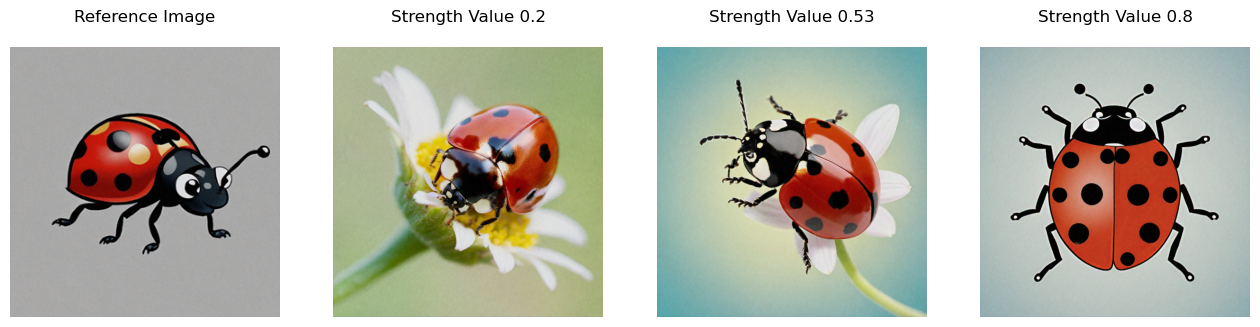

In [9]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image with different similarityStrength values
generated_images = []
for value in strength_values:
    response = bedrock_runtime.invoke_model(
        body = json.dumps({
            "taskType": "IMAGE_VARIATION",
            "imageVariationParams": {
                "text": prompt,
                "images": [reference_image_base64], # can provide up to 5 reference images here
                "similarityStrength": value,  # between 0.2 to 1
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "quality": "premium",
                "seed": seed
            }
        }),
        modelId = "amazon.titan-image-generator-v1",
        accept="application/json",
        contentType="application/json"
        )

    response_body = json.loads(response.get("body").read())
    
    generated_img = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
    ]
    generated_images.append(generated_img[0])
    
    
# plot comparison images    
plot_images(reference_image_path, generated_images=generated_images, 
            strength_values=strength_values, prompt=prompt, comparison_mode=True)

It can be seen that when using lower `similarityStrength` value, the generated image will primarily follow the content of the text prompt, with only a subtle influence from the reference image's style. As the value increases, the reference image's style becomes more dominant, potentially overriding some aspects of the text prompt's content.

User should adjust this parameter based on their desired balance between content and style, considering the specific text prompt and reference image being used. 

## Take Away

Amazon Titan Image Generator's Instant Customization feature opens up a world of creative possibilities for generating images with specific styles and variations. We encourage you to explore this feature and unleash your creativity. Experiment with different reference images, text prompts and similarity strengths to discover the endless possibilities of image generation.